# Dependencies 

In [1]:
import sys
sys.path.append('src/')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
import seaborn as sns
from glob import glob
from itertools import product
from mrk_file import MRKFile

%matplotlib inline

pd.options.display.max_columns = None

# Helper Functions

In [2]:
def load_mrk_files_from_folder(folder_path):
    mrk_filepaths = glob(os.path.join(folder_path, '*.mrk'))
    
    mrk_files = []
    for i, mrk_path in enumerate(mrk_filepaths):
        print('{} of {}'.format(i+1, len(mrk_filepaths)), end='\r')
        mrk_files.append(MRKFile(mrk_path))
    print()
    return mrk_files

def requirements_statistics_from_dataset(list_mrk_files):
    reqs_comp, reqs_non_comp, reqs_dummy = [], [], []
    req_names = [req.description for req in list_mrk_files[0].photo_reqs]
    
    for mrk_file in list_mrk_files:
        reqs_comp.append([req.is_compliant() for req in mrk_file.photo_reqs])
        reqs_non_comp.append([req.is_non_compliant() for req in mrk_file.photo_reqs])
        reqs_dummy.append([req.is_dummy() for req in mrk_file.photo_reqs])
        
    counts_comp = np.array(reqs_comp).sum(axis=0)
    counts_non_comp = np.array(reqs_non_comp).sum(axis=0)
    counts_dummy = np.array(reqs_dummy).sum(axis=0)

    df_stats = pd.DataFrame(np.vstack((counts_comp, counts_non_comp, counts_dummy)).T, 
                            index=req_names, 
                            columns=['C', 'NC', 'D'])
    return df_stats

def plot_requirements_statistics(df_stats):
    ax = df_stats.plot(kind='barh', stacked=True, figsize=(10, 8))
    ax.invert_yaxis()
    
def requirements_correlation(list_mrk_files, cond=lambda a, b: a.is_non_compliant() and b.is_dummy()):
    n_reqs = 23
    corr_matrix = np.zeros((n_reqs * n_reqs,), dtype=np.uint8)
    for i, mrk_file in enumerate(list_mrk_files):
        list_corrs = []
        for req_i, req_j in product(mrk_file.photo_reqs, repeat=2):
            list_corrs.append(int(cond(req_i, req_j)))
        corr_matrix = corr_matrix + list_corrs
        
    corr_matrix = corr_matrix.reshape((n_reqs, n_reqs))
    plt.figure(figsize=(10, 10))
    labels = ['{} [{}]'.format(name, i) for i, name in enumerate(req_names)]
    sns.heatmap(corr_matrix, cmap=plt.cm.Blues, annot=True, fmt='d', cbar=False, mask=(corr_matrix == 0), yticklabels=labels)

# Data Loading

In [3]:
mrk_train = load_mrk_files_from_folder('data/train/ground_truth/')
mrk_val = load_mrk_files_from_folder('data/val/FVC/ground_truth/')

5211 of 5211


565 of 565


In [4]:
req_names = [req.description for req in mrk_val[0].photo_reqs]
n_reqs = len(req_names)

print(n_reqs)
print('\n'.join(req_names))

23
Blurred
Looking away
Ink marked/creased
Unnatural skin tone
Too dark/light
Washed out
Pixelation
Hair across eyes
Eyes closed
Varied background
Roll/pitch/yaw rotations greater than a predefined thresholds
Flash reflection on skin
Red eyes
Shadows behind head
Shadows across face
Dark tinted lenses
Flash reflection on lenses
Frames too heavy
Frame covering eyes
Hat/cap
Veil over face
Mouth open
Presence of other faces or toys too close to face


# Data Analysis

## Requirements per Dataset 

,C,NC,D
Blurred,509,31,25
Looking away,427,32,106
Ink marked/creased,565,0,0
Unnatural skin tone,401,37,127
Too dark/light,497,38,30
Washed out,531,33,1
Pixelation,536,29,0
Hair across eyes,517,12,36
Eyes closed,468,31,66
Varied background,329,155,81


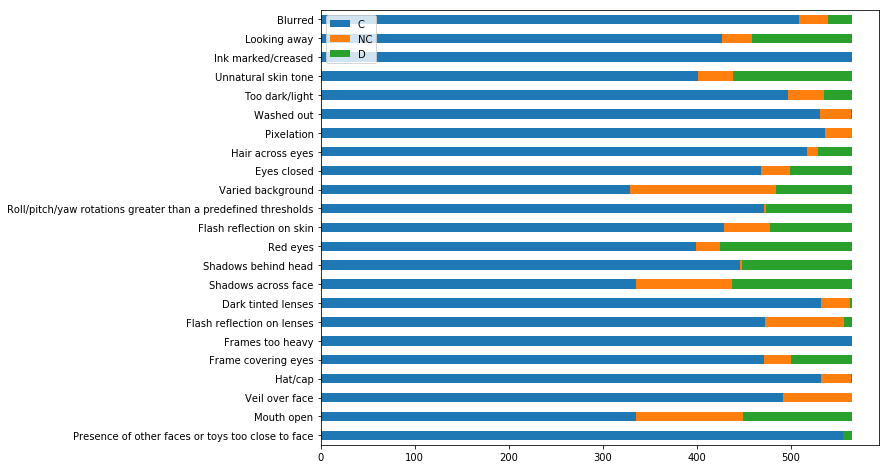

In [5]:
df_val = requirements_statistics_from_dataset(mrk_val)

plot_requirements_statistics(df_val)
df_val

,C,NC,D
Blurred,4330,726,155
Looking away,3644,588,979
Ink marked/creased,4976,3,232
Unnatural skin tone,4899,150,162
Too dark/light,4911,259,41
Washed out,5206,2,3
Pixelation,4847,362,2
Hair across eyes,4481,648,82
Eyes closed,4128,449,634
Varied background,3740,1465,6


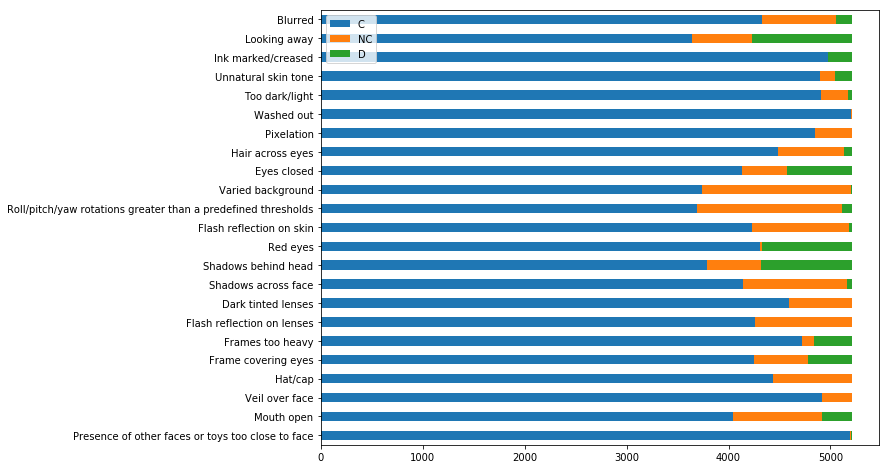

In [6]:
df_train = requirements_statistics_from_dataset(mrk_train)
plot_requirements_statistics(df_train)
df_train

## Proportion of Requirements per Dataset

In [7]:
df_train_prop = df_train.div(df_train.sum(axis=1), axis=0)
df_train_prop * 100

,C,NC,D
Blurred,83.093456,13.932067,2.974477
Looking away,69.928996,11.283823,18.787181
Ink marked/creased,95.490309,0.057571,4.452121
Unnatural skin tone,94.012666,2.878526,3.108808
Too dark/light,94.242948,4.970255,0.786797
Washed out,99.904049,0.038380,0.057571
Pixelation,93.014776,6.946843,0.038380
Hair across eyes,85.991173,12.435233,1.573594
Eyes closed,79.217041,8.616388,12.166571
Varied background,71.771253,28.113606,0.115141


In [8]:
np.savetxt('data/train_max_proportions.txt', df_train_prop.max(axis=1).values, fmt='%.8f')

In [9]:
df_val_prop = df_val.div(df_val.sum(axis=1), axis=0)
df_val_prop * 100

,C,NC,D
Blurred,90.088496,5.486726,4.424779
Looking away,75.575221,5.663717,18.761062
Ink marked/creased,100.000000,0.000000,0.000000
Unnatural skin tone,70.973451,6.548673,22.477876
Too dark/light,87.964602,6.725664,5.309735
Washed out,93.982301,5.840708,0.176991
Pixelation,94.867257,5.132743,0.000000
Hair across eyes,91.504425,2.123894,6.371681
Eyes closed,82.831858,5.486726,11.681416
Varied background,58.230088,27.433628,14.336283


In [10]:
np.savetxt('data/val_max_proportions.txt', df_val_prop.max(axis=1).values, fmt='%.8f')

## Non-compliant requirements

In [11]:
df_nc_train_val = pd.concat((df_train.NC, df_val.NC), axis=1)
df_nc_train_val.columns = ['Train', 'Val']
df_nc_train_val

,Train,Val
Blurred,726,31
Looking away,588,32
Ink marked/creased,3,0
Unnatural skin tone,150,37
Too dark/light,259,38
Washed out,2,33
Pixelation,362,29
Hair across eyes,648,12
Eyes closed,449,31
Varied background,1465,155


## Correlation between Requirements 

### Non-compliant and Dummy Requirements 

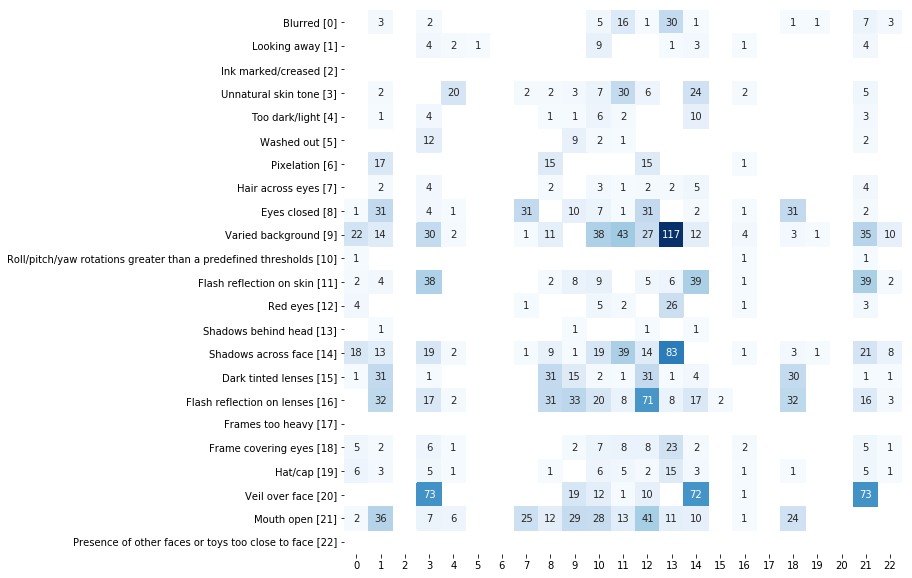

In [12]:
requirements_correlation(mrk_val)

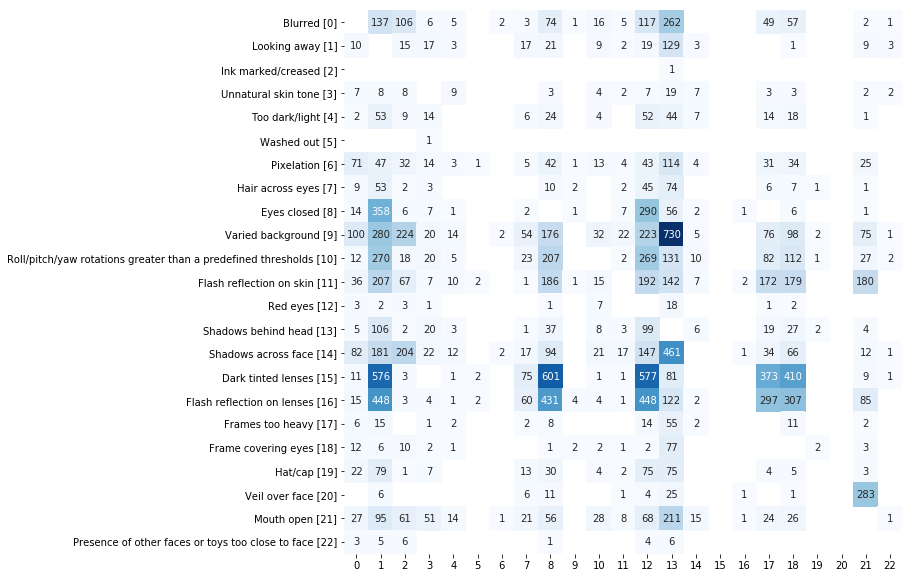

In [13]:
requirements_correlation(mrk_train)

### Dummy Requirements

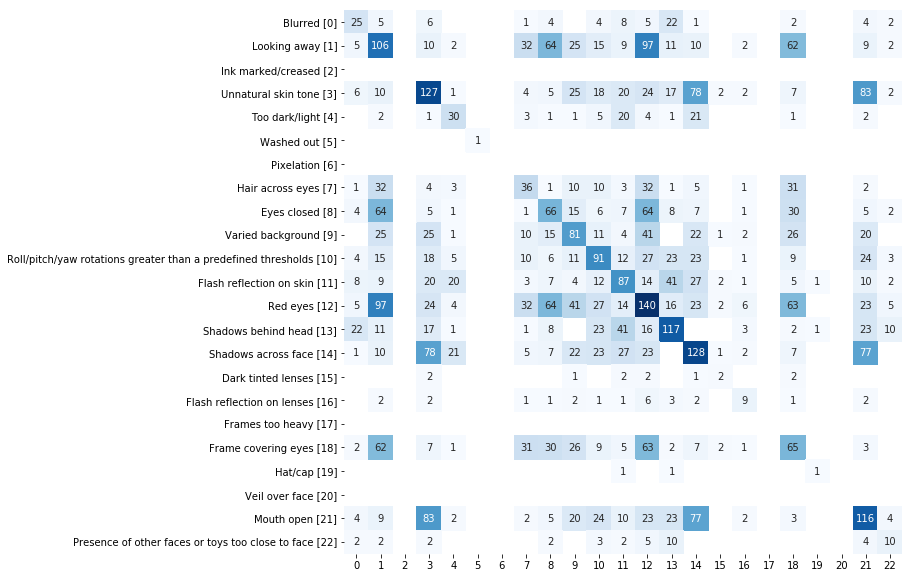

In [14]:
requirements_correlation(mrk_val, lambda a, b: a.is_dummy() and b.is_dummy())

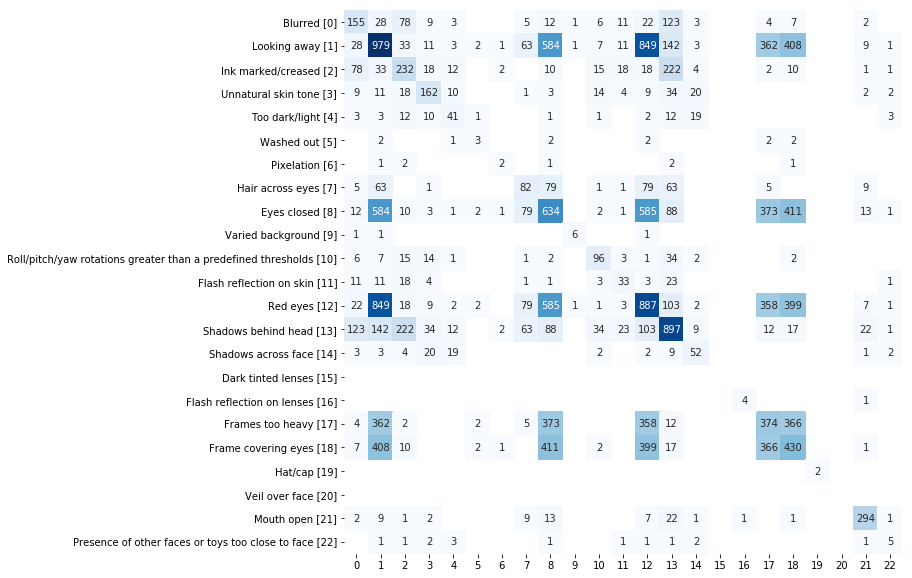

In [15]:
requirements_correlation(mrk_train, lambda a, b: a.is_dummy() and b.is_dummy())